# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


#📒Hyperparameters

In [3]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 0.1

#  number of classes after mapping
NUM_CLASSES = 5

# SEED
seed = 42

# ⏳ Load the Data

In [4]:
# Load the dataset
data = np.load("mars_for_students.npz")

# Extract training set and test set
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

# Print the number of samples in each set
print(f"\nNumber of samples:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(y_train)}")
print(f"Test: {len(X_test)}")


Number of samples:
Train: 2615
Validation: 2615
Test: 10022


#🧐Inspect Data

## ❌ Data Clean

###🚀Utilities for data cleaning

In [5]:
import hashlib
import numpy as np

# Function: Compute hash for a mask
def compute_hash(mask):
    """
    Compute a unique hash for a given mask or image.

    Args:
        mask (ndarray): Mask or image array, shape (H, W) or (H, W, C).

    Returns:
        str: Hash value as a string.
    """
    return hashlib.md5(mask.tobytes()).hexdigest()

# Function: Save hashes to a file
def save_hashes(hashes, file_path="mask_hashes.txt"):
    """
    Save a list of hash values to a file.

    Args:
        hashes (list): List of hash values.
        file_path (str): Path to save the file.
    """
    with open(file_path, "w") as f:
        for h in hashes:
            f.write(h + "\n")
    print(f"Hashes saved to {file_path}")

# Function: Load hashes from a file
def load_hashes(file_path="mask_hashes.txt"):
    """
    Load a list of hash values from a file.

    Args:
        file_path (str): Path to the file containing hashes.

    Returns:
        list: List of hash values.
    """
    with open(file_path, "r") as f:
        hashes = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(hashes)} hashes from {file_path}")
    return hashes

# Function: Find indices of masks by hash
def find_masks_by_hash(masks, hash_list):
    """
    Find indices of masks that match any hash in the hash list.

    Args:
        masks (ndarray): Array of masks, shape (N, H, W).
        hash_list (list): List of hash values to match.

    Returns:
        list: Indices of masks that match the given hashes.
    """
    similar_indices = []
    matching_hashes = []
    for idx, mask in enumerate(masks):
        hash_value = compute_hash(mask)
        if hash_value in hash_list:
            similar_indices.append(idx)
            matching_hashes.append(hash_value)
    return similar_indices, matching_hashes

# Function: Remove images and masks by indices
def remove_indices(images, masks, indices):
    """
    Remove images and masks corresponding to the given indices.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        masks (ndarray): Array of masks, shape (N, H, W).
        indices (list): List of indices to remove.

    Returns:
        tuple: Cleaned images and masks.
    """
    images_cleaned = np.delete(images, indices, axis=0)
    masks_cleaned = np.delete(masks, indices, axis=0)
    return images_cleaned, masks_cleaned

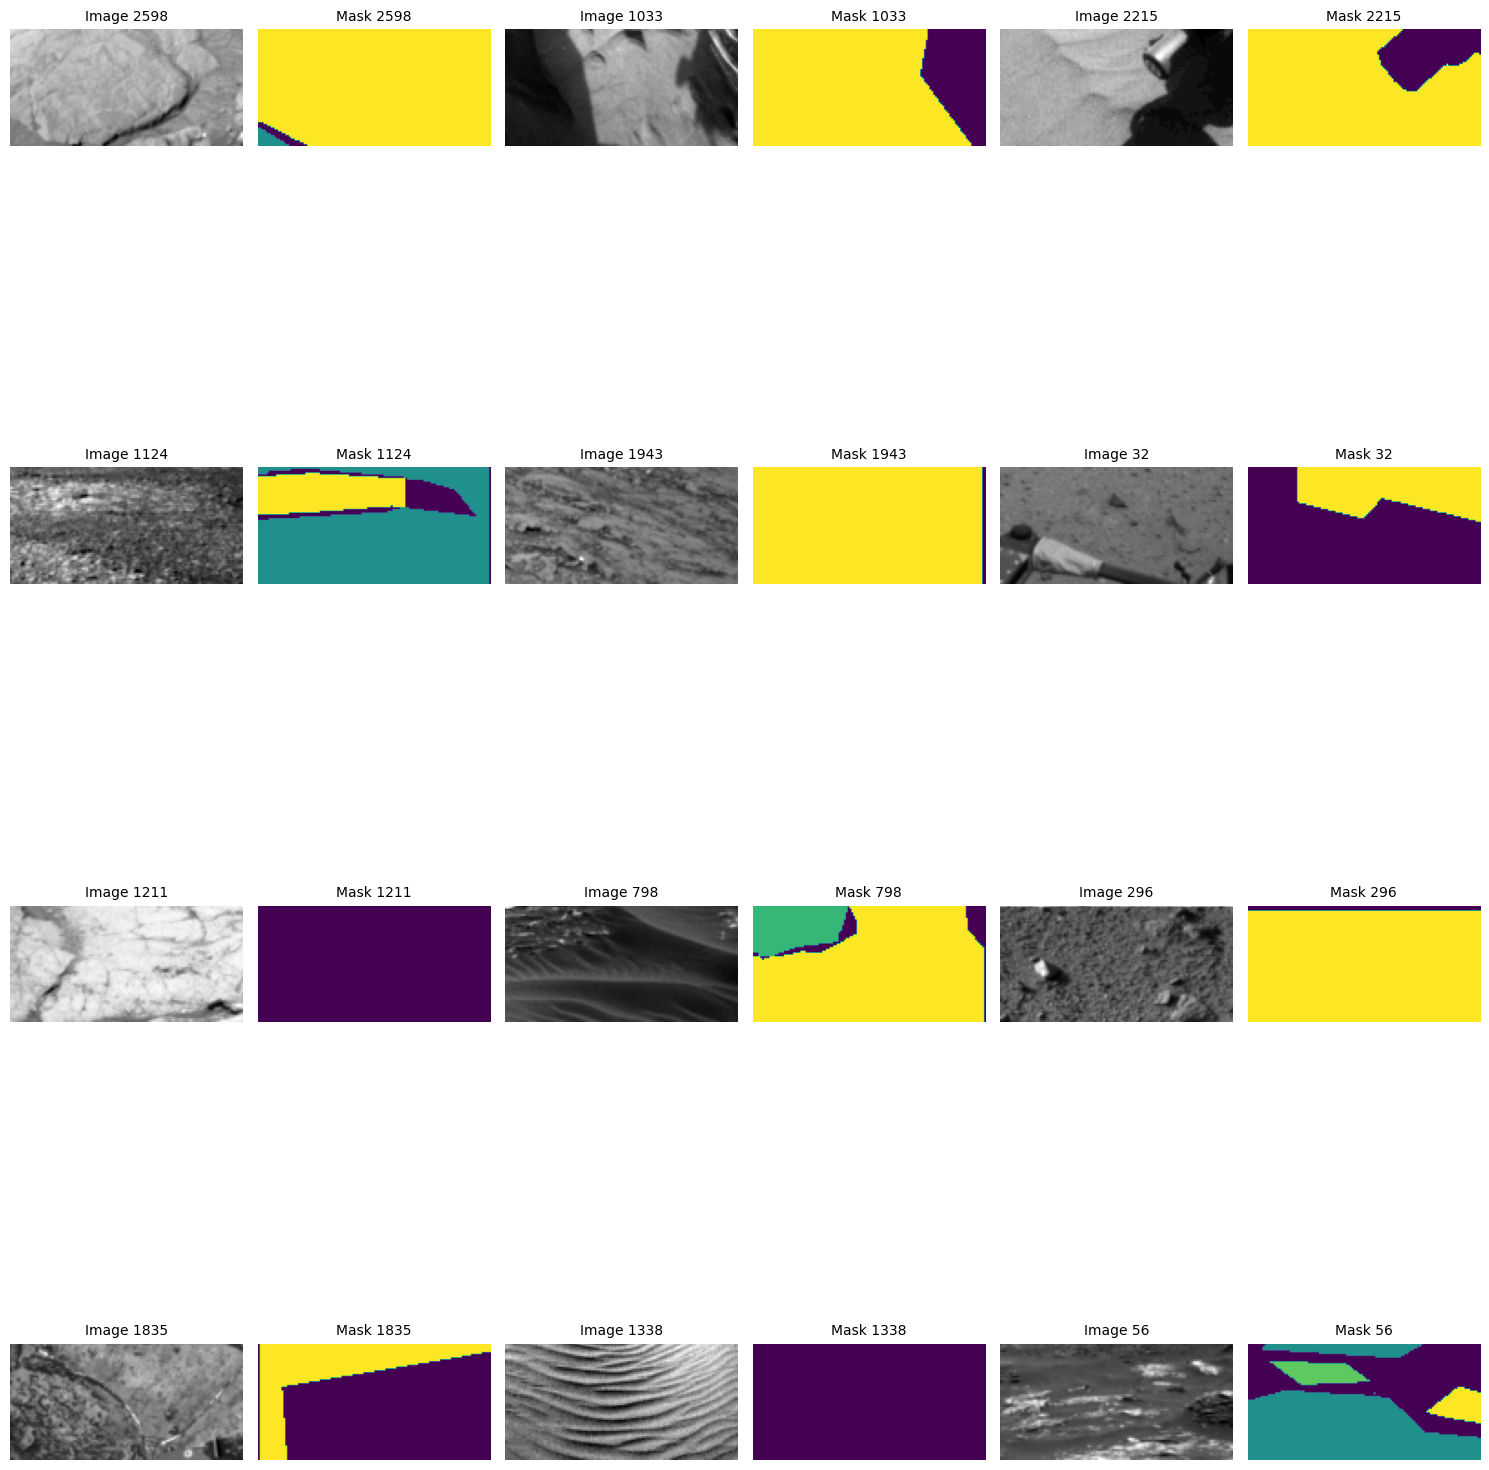

In [6]:
# Inspect random images and their corresponding masks
def inspect_random_images_and_masks_side_by_side(images, masks, num_samples=21, images_per_row=3):
    """
    Randomly visualize images and their corresponding masks side by side in a multi-row layout.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        masks (ndarray): Array of masks, shape (N, H, W).
        num_samples (int): Number of samples to display.
        images_per_row (int): Number of image-mask pairs per row.
    """
    random_indices = np.random.choice(len(images), num_samples, replace=False)  # Randomly select indices
    num_rows = (num_samples + images_per_row - 1) // images_per_row  # Calculate number of rows

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust height for multiple rows

    for i, idx in enumerate(random_indices):
        # Calculate position for the image and mask
        row = i // images_per_row
        col = (i % images_per_row) * 2  # Each image-mask pair occupies two columns

        # Display the image
        plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 1)  # Image position
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Image {idx}", fontsize=10)
        plt.axis('off')

        # Display the corresponding mask
        plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 2)  # Mask position
        plt.imshow(masks[idx].squeeze(), cmap='viridis')
        plt.title(f"Mask {idx}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Randomly display 12 image-mask pairs from X_train and y_train
inspect_random_images_and_masks_side_by_side(X_train, y_train, num_samples=12, images_per_row=3)




In [7]:


# Main Workflow
def clean_dataset_by_hash_with_print(images, masks, template_indices):
    """
    Remove all images and masks that match the hashes of given template indices and print hashes.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        masks (ndarray): Array of masks, shape (N, H, W).
        template_indices (list): Indices of known templates to compute hashes.

    Returns:
        tuple: Cleaned images and masks.
    """
    # Step 1: Compute hashes for template masks
    template_hashes = [compute_hash(masks[idx]) for idx in template_indices]
    print("Hashes for template masks (copy and save these):")
    for idx, h in zip(template_indices, template_hashes):
        print(f"Template Index {idx}: {h}")

    # Step 2: Find all matching masks in the dataset
    matching_indices, matching_hashes = find_masks_by_hash(masks, template_hashes)
    print("\nHashes for detected masks:")
    for idx, h in zip(matching_indices, matching_hashes):
        print(f"Matched Index {idx}: {h}")

    print(f"\nTotal matching masks found: {len(matching_indices)}")

    # Step 3: Remove matching images and masks
    images_cleaned, masks_cleaned = remove_indices(images, masks, matching_indices)
    return images_cleaned, masks_cleaned







hash:6d1c485f0a55ea81753b5c6cf66fca1a

In [8]:

# Known template indices with alien masks
alien_template_indices = [426]  # Add indices of known alien masks

# Clean the dataset and print hashes
X_train_cleaned, y_train_cleaned = clean_dataset_by_hash_with_print(X_train, y_train, alien_template_indices)

# Output dataset sizes
print(f"\nOriginal dataset size: {len(X_train)}")
print(f"Cleaned dataset size: {len(X_train_cleaned)}")


Hashes for template masks (copy and save these):
Template Index 426: 6d1c485f0a55ea81753b5c6cf66fca1a

Hashes for detected masks:
Matched Index 62: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 79: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 125: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 139: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 142: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 147: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 152: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 156: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 170: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 210: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 217: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 266: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 289: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 299: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 313: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 339: 6d1c485f0a55ea81753b5c6cf66fca1a
Matched Index 348: 6d1c485f0a55ea81753b5

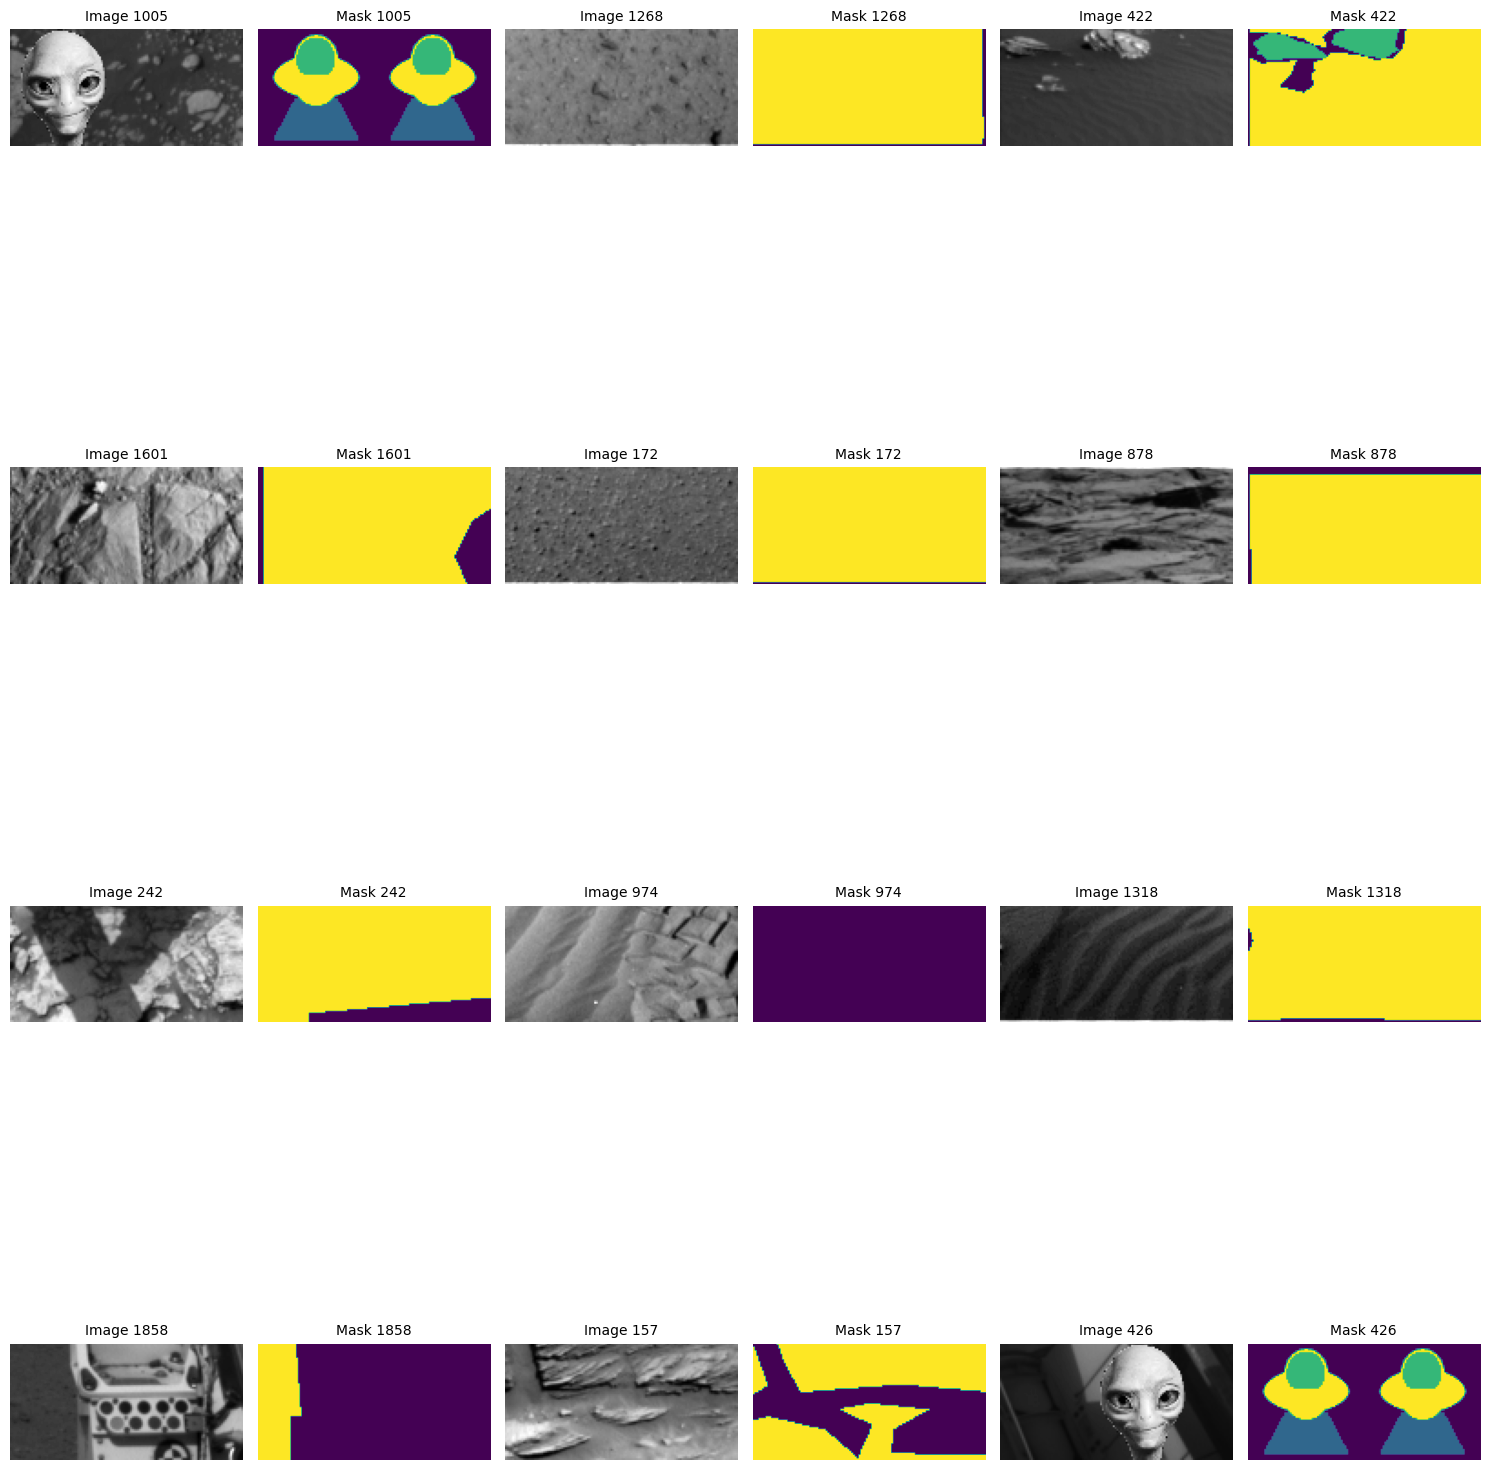

In [9]:
# Inspect random images and their corresponding masks
def inspect_random_images_and_masks_side_by_side(images, masks, num_samples=21, images_per_row=3):
    """
    Randomly visualize images and their corresponding masks side by side in a multi-row layout.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        masks (ndarray): Array of masks, shape (N, H, W).
        num_samples (int): Number of samples to display.
        images_per_row (int): Number of image-mask pairs per row.
    """
    random_indices = np.random.choice(len(images), num_samples, replace=False)  # Randomly select indices
    num_rows = (num_samples + images_per_row - 1) // images_per_row  # Calculate number of rows

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust height for multiple rows

    for i, idx in enumerate(random_indices):
        # Calculate position for the image and mask
        row = i // images_per_row
        col = (i % images_per_row) * 2  # Each image-mask pair occupies two columns

        # Display the image
        plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 1)  # Image position
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Image {idx}", fontsize=10)
        plt.axis('off')

        # Display the corresponding mask
        plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 2)  # Mask position
        plt.imshow(masks[idx].squeeze(), cmap='viridis')
        plt.title(f"Mask {idx}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Randomly display 12 image-mask pairs from X_train and y_train
inspect_random_images_and_masks_side_by_side(X_train, y_train, num_samples=12, images_per_row=3)

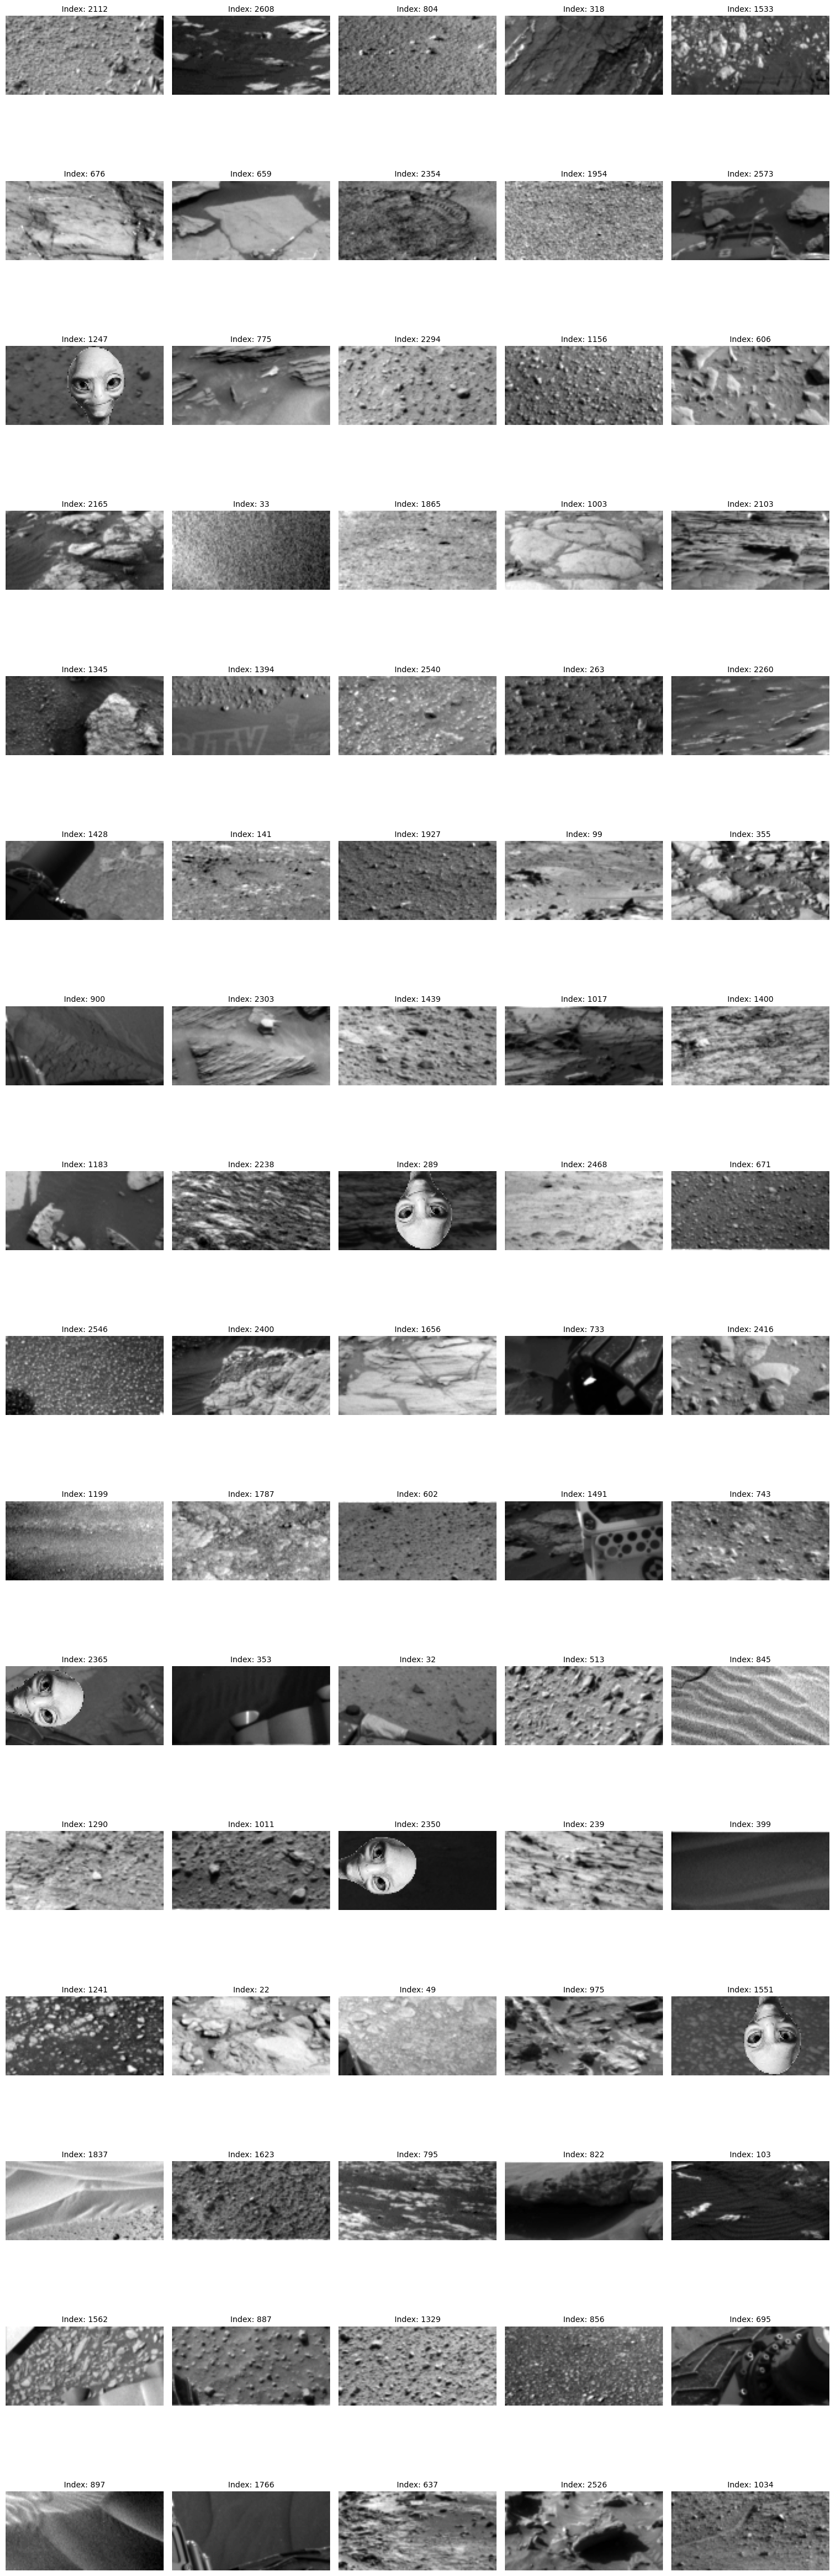

In [10]:


def display_random_images(images, num_images=20, images_per_row=5):
    """
    Display a random selection of images from the dataset with multi-row layout.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        num_images (int): Number of images to display.
        images_per_row (int): Number of images per row.
    """
    # Randomly select indices
    random_indices = np.random.choice(len(images), num_images, replace=False)

    # Calculate the number of rows needed
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Ceiling division

    # Plot the images
    plt.figure(figsize=(15, 3 * num_rows))
    for i, idx in enumerate(random_indices):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Index: {idx}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 20 random images
display_random_images(X_train, num_images=80, images_per_row=5)


###🚀Remove Alien

In [11]:
# Hash value to be removed
target_hash = "6d1c485f0a55ea81753b5c6cf66fca1a"

def clean_dataset_by_target_hash(images, masks, target_hash):
    """
    Remove all images and masks where the mask hash matches the given target hash.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        masks (ndarray): Array of masks, shape (N, H, W).
        target_hash (str): The hash value to match and remove.

    Returns:
        tuple: Cleaned images and masks.
    """
    matching_indices = []
    for idx, mask in enumerate(masks):
        if compute_hash(mask) == target_hash:
            matching_indices.append(idx)

    # Print matching indices
    print(f"Found {len(matching_indices)} masks with hash {target_hash}: {matching_indices}")

    # Remove matching images and masks
    images_cleaned, masks_cleaned = remove_indices(images, masks, matching_indices)
    return images_cleaned, masks_cleaned

# Example usage:
# Assuming `X_train` and `y_train` are the loaded dataset

# Clean the dataset
X_train_cleaned, y_train_cleaned = clean_dataset_by_target_hash(X_train, y_train, target_hash)

# Output dataset sizes
print(f"Original dataset size: {len(X_train)}")
print(f"Cleaned dataset size: {len(X_train_cleaned)}")


Found 110 masks with hash 6d1c485f0a55ea81753b5c6cf66fca1a: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
Original dataset size: 2615
Cleaned dataset size: 2505


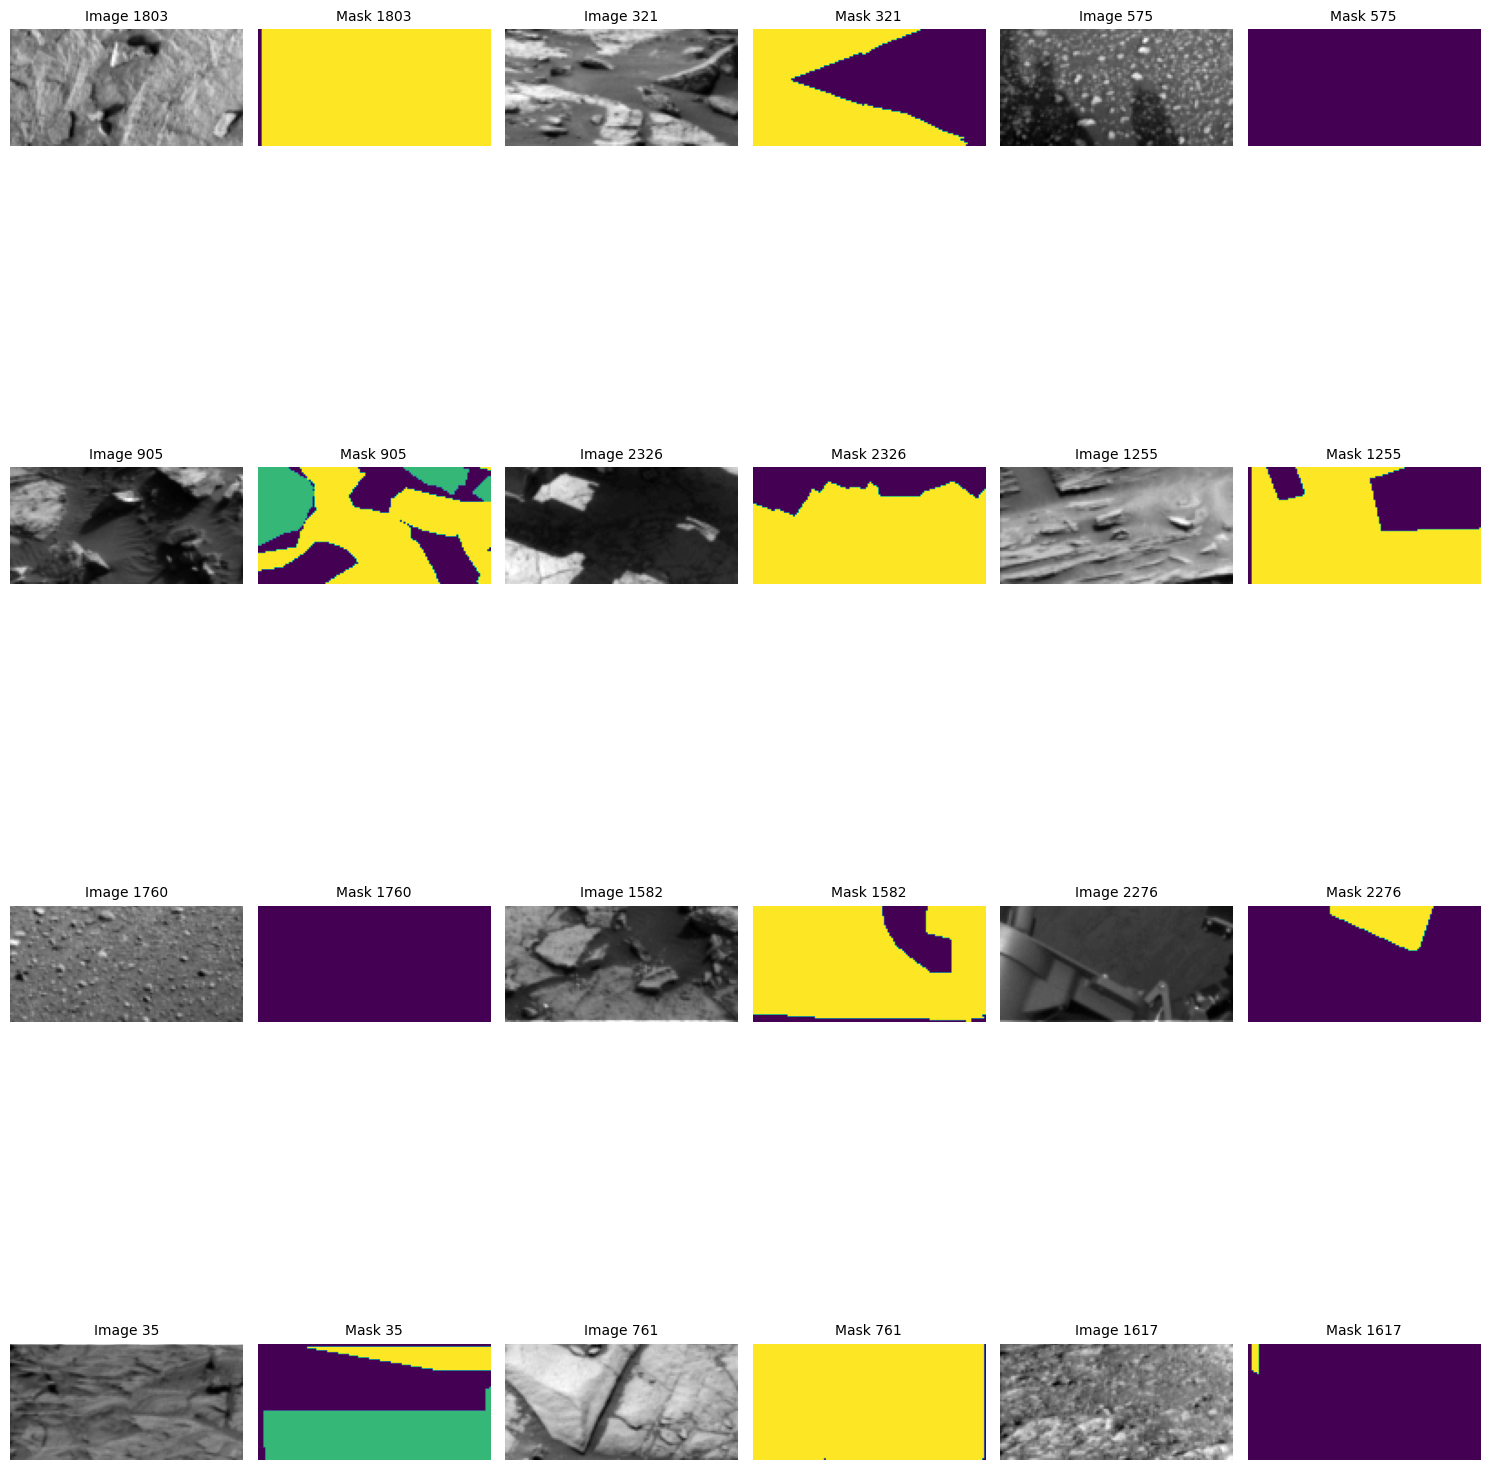

In [12]:

# Inspect random images and their corresponding masks
def inspect_random_images_and_masks_side_by_side(images, masks, num_samples=21, images_per_row=3):
    """
    Randomly visualize images and their corresponding masks side by side in a multi-row layout.

    Args:
        images (ndarray): Array of images, shape (N, H, W).
        masks (ndarray): Array of masks, shape (N, H, W).
        num_samples (int): Number of samples to display.
        images_per_row (int): Number of image-mask pairs per row.
    """
    random_indices = np.random.choice(len(images), num_samples, replace=False)  # Randomly select indices
    num_rows = (num_samples + images_per_row - 1) // images_per_row  # Calculate number of rows

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust height for multiple rows

    for i, idx in enumerate(random_indices):
        # Calculate position for the image and mask
        row = i // images_per_row
        col = (i % images_per_row) * 2  # Each image-mask pair occupies two columns

        # Display the image
        plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 1)  # Image position
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Image {idx}", fontsize=10)
        plt.axis('off')

        # Display the corresponding mask
        plt.subplot(num_rows, images_per_row * 2, row * images_per_row * 2 + col + 2)  # Mask position
        plt.imshow(masks[idx].squeeze(), cmap='viridis')
        plt.title(f"Mask {idx}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Randomly display 12 image-mask pairs from X_train and y_train
inspect_random_images_and_masks_side_by_side(X_train_cleaned, y_train_cleaned, num_samples=12, images_per_row=3)

##🚨 Data Augmentation

In [13]:
import tensorflow as tf

@tf.function
def adaptive_random_brightness(image, label):
    """Dynamically adjust brightness based on the image's current brightness."""
    # Calculate mean brightness
    mean_brightness = tf.reduce_mean(image)

    # Convert mean_brightness to a Python bool for tf.cond
    condition = tf.greater(mean_brightness, 0.7)  # True if mean_brightness > 0.7

    # Define a function for each branch of tf.cond using Python control flow
    def true_fn():
        return tf.image.random_brightness(image, max_delta=0.1)
    def false_fn():
        return tf.image.random_brightness(image, max_delta=0.2)

    # Use tf.cond to apply random_brightness based on the condition
    image = tf.cond(condition, true_fn, false_fn)
    return image, label

@tf.function
def adaptive_random_contrast(image, label):
    """Dynamically adjust contrast based on the image's current contrast."""
    current_mean = tf.reduce_mean(image)
    variance = tf.reduce_mean(tf.square(image - current_mean))
    stddev = tf.sqrt(variance)

    # Convert stddev to Python bool for tf.cond
    condition = tf.greater(stddev, 0.5)  # True if stddev > 0.5

    def true_fn():
        return tf.image.random_contrast(image, lower=0.9, upper=1.1)
    def false_fn():
        return tf.image.random_contrast(image, lower=0.7, upper=1.3)

    image = tf.cond(condition, true_fn, false_fn)
    return image, label

In [14]:
import tensorflow as tf
import numpy as np
#import tensorflow_addons as tfa

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

@tf.function
def random_flip_both_directions(image, label, seed=None):
    """Randomly perform both horizontal and vertical flips independently."""
    if seed is not None:
        tf.random.set_seed(seed)  # Optionally set seed for consistency

    # Horizontal flip with its own random decision
    horizontal_flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        horizontal_flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        horizontal_flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    # Vertical flip with its own random decision
    vertical_flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        vertical_flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        vertical_flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )

    return image, label

@tf.function
def random_brightness(image, label):
    """Randomly adjust brightness of the image."""
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness for grayscale
    return image, label

@tf.function
def random_contrast(image, label):
    """Randomly adjust contrast of the image."""
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)  # Adjust contrast for grayscale
    return image, label

@tf.function
def random_crop(image, label, min_crop_size=(10, 20), max_crop_size=(64, 128)):
    """Randomly crop the image and label with random crop size."""
    # Get original image and label shapes using .shape instead of tf.shape
    image_shape = image.shape
    label_shape = label.shape

    # Randomly choose crop height and width within the range
    crop_height = tf.random.uniform([], min_crop_size[0], max_crop_size[0], dtype=tf.int32)
    crop_width = tf.random.uniform([], min_crop_size[1], max_crop_size[1], dtype=tf.int32)

    # Ensure that crop size is smaller than the image size, using numpy objects
    if crop_height >= image_shape[0] or crop_width >= image_shape[1]:
        # in case of invalid crop size, just return original image
        return image, label

    # Randomly choose offset for cropping
    offset_height = tf.random.uniform([], 0, image_shape[0] - crop_height, dtype=tf.int32)
    offset_width = tf.random.uniform([], 0, image_shape[1] - crop_width, dtype=tf.int32)

    # Perform cropping
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_height, crop_width)
    label_cropped = tf.image.crop_to_bounding_box(label, offset_height, offset_width, crop_height, crop_width)

    # Resize cropped image and label back to original size
    image_resized = tf.image.resize(image_cropped, [image_shape[0], image_shape[1]])
    label_resized = tf.image.resize(label_cropped, [label_shape[0], label_shape[1]], method='nearest')

    return image_resized, label_resized

@tf.function
def random_rotation(image, label, seed=None):
    """Randomly rotate the image and label."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Randomly choose between 0 degrees (k=0) and 180 degrees (k=2)
    angle = tf.random.uniform([], 0, 2, dtype=tf.int32)  # Generates either 0 or 1


    # If angle is 1, then we perform a 180 degree rotation (k=2)
    # If angle is 0, no rotation is performed (k=0)
    image = tf.image.rot90(image, k=2 * angle)
    label = tf.image.rot90(label, k=2 * angle)

    return image, label

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)


#💻Data Preprocessing

### 🧩 Split Dataset

In [15]:
X_test =X_test[...,np.newaxis]/ 255.0

X_train, X_val, y_train, y_val = train_test_split(
    X_train_cleaned,  # Cleaned training images
    y_train_cleaned,  # Cleaned training masks
    test_size=SPLITS_SIZE,
    random_state=seed
)

In [16]:
# Category mapping
category_map = {
    0:0, #"Background",
    1:1, #"Soil",
    2:2, #"Bedrock",
    3:3, #"Sand",
    4:4, #"Big Rock"
}

In [75]:
from collections import Counter


def calculate_class_distribution(masks):
    class_distribution = Counter()
    for mask in masks:
        unique, counts = np.unique(mask, return_counts=True)
        class_distribution.update(dict(zip(unique, counts)))
    return class_distribution


In [76]:

data = np.load("mars_for_students.npz")
masks = data['training_set'][:, 1]


class_distribution = calculate_class_distribution(masks)
print("类别分布统计:")
for class_id, count in class_distribution.items():
    print(f"{category_map[class_id]} (Class {class_id}): {count} pixels")

类别分布统计:
0 (Class 0.0): 5466886 pixels
2 (Class 2.0): 4863930 pixels
3 (Class 3.0): 3933183 pixels
1 (Class 1.0): 7131118 pixels
4 (Class 4.0): 26963 pixels


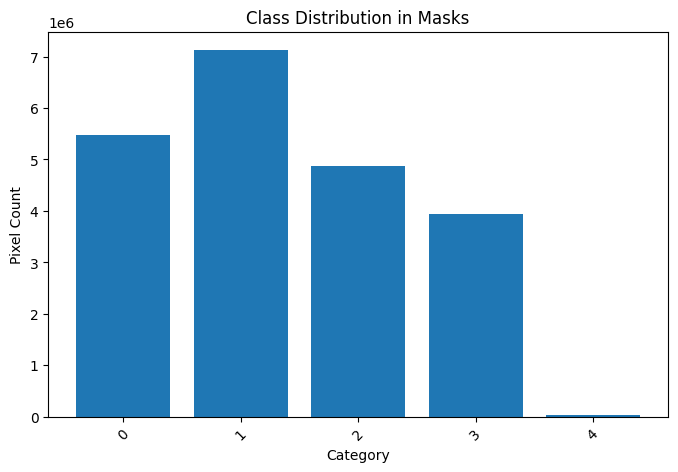

In [77]:

def plot_class_distribution(class_distribution, category_mapping):
    labels = [category_mapping[class_id] for class_id in class_distribution.keys()]
    counts = list(class_distribution.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts)
    plt.xlabel("Category")
    plt.ylabel("Pixel Count")
    plt.title("Class Distribution in Masks")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(class_distribution, category_map)


### 📦Create Dataset

In [20]:
def load_single_image(image_array, label_array, input_size=(64, 128)):
    """
    Load and preprocess a single image-label pair directly from 2D numpy arrays.
    """
    # Process the image: ensure it has 3 dimensions (H, W, 1)
    image = tf.cast(image_array, dtype=tf.float32)
    if len(image.shape) == 2:  # If 2D, expand to 3D (H, W, 1)
        image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, input_size)  # Resize to fixed size
    image = image / 255.0  # Normalize to [0, 1]

    # Process the label: ensure it has 3 dimensions (H, W, 1)
    label = tf.cast(label_array, dtype=tf.int32)
    if len(label.shape) == 2:  # If 2D, expand to 3D (H, W, 1)
        label = tf.expand_dims(label, axis=-1)

    # Resize to (16, 32) to match UNet output shape. Use nearest neighbor to avoid changing categories in label
    label = tf.image.resize(label, [16, 32], method='nearest')  # Resize to fixed size

    label = tf.cast(label, tf.int32)  # Ensure integer type

    return image, label


In [21]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset from 2D numpy arrays with all data augmentations.
    """
    # Create dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        # Shuffle the dataset to randomize the order of samples
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load and preprocess images and labels
    dataset = dataset.map(
        lambda img, lbl: load_single_image(img, lbl),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping to labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
         # Apply both flip
        dataset = dataset.map(
            lambda x, y: random_flip_both_directions(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

         # Apply random brightness
        #dataset = dataset.map(
        #    lambda x, y: random_brightness(x, y),
        #    num_parallel_calls=tf.data.AUTOTUNE
        #)

        # Apply random contrast
        #dataset = dataset.map(
        #    lambda x, y: random_contrast(x, y),
        #    num_parallel_calls=tf.data.AUTOTUNE
        #)

        # Apply Dynamic brightness
        dataset = dataset.map(
            lambda x, y: adaptive_random_brightness(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Apply Dynamic contrast
        dataset = dataset.map(
            lambda x, y: adaptive_random_contrast(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )


        # Apply random rotation (0 or 180 grades)
        dataset = dataset.map(
            lambda x, y: random_rotation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Apply any rotation (0 or 360 grades)
        #dataset = dataset.map(
        #    lambda x, y: random_rotation_any_angle(x, y, seed=seed),
        #    num_parallel_calls=tf.data.AUTOTUNE
        #)



       #dataset = dataset.map(
       #     lambda x, y: apply_augmentations(x, y, seed=seed),
       #     num_parallel_calls=tf.data.AUTOTUNE
       # )



        # Apply random noise
       # dataset = dataset.map(
       #     lambda x, y: random_gaussian_noise(x, y, stddev=0.01),
       #     num_parallel_calls=tf.data.AUTOTUNE
       # )


    # Batch the dataset
    dataset = dataset.batch(batch_size, drop_remainder=False)  # Group samples into batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch to improve input pipeline performance

    return dataset

In [74]:

# Create the datasets
print("Creating datasets...")
BATCH_SIZE = 32  # Define batch size
seed = 42  # Define random seed for reproducibility

# Create training dataset with augmentation
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,  # Enable data augmentation for training
    seed=seed
)

# Create validation dataset without augmentation
val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No augmentation for
    augment=False,  #
    seed=seed
)

print("Datasets created!")



Creating datasets...
Datasets created!


In [23]:
print(y_train.shape)

(2254, 64, 128)


In [73]:

class_distribution = calculate_class_distribution(y_train)
print("class_distribution:")
for class_id, count in class_distribution.items():
    print(f"{category_map[class_id]} (Class {class_id}): {count} pixels")

class_distribution:
0 (Class 0.0): 4508320 pixels
1 (Class 1.0): 6259362 pixels
2 (Class 2.0): 4331492 pixels
3 (Class 3.0): 3339887 pixels
4 (Class 4.0): 25707 pixels


In [25]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored

def add_colormap_legend(colormap, num_classes):
    """
    Add a legend to the plot showing the mapping of labels to colors.
    """
    import matplotlib.patches as mpatches
    patches = []
    for i in range(num_classes):
        color = colormap[i]
        rgb_color = (color[0], color[1], color[2])
        patch = mpatches.Patch(color=rgb_color, label=f"Label {i}")
        patches.append(patch)
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image in grayscale
            plt.subplot(num_samples, 3, j * 3 + 1)
            plt.imshow(images[j].squeeze(), cmap='gray')  # Ensure grayscale display
            plt.title(f'Input Image {j+1}')
            plt.axis('off')

            # Plot colored ground truth label
            plt.subplot(num_samples, 3, j * 3 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Ground Truth Mask {j+1}')
            plt.axis('off')

            # Plot placeholder for predicted mask (if applicable)
            # You can replace this with actual predictions
            plt.subplot(num_samples, 3, j * 3 + 3)
            plt.imshow(colored_label)  # Replace with predictions if available
            plt.title(f'Predicted Mask {j+1}')
            plt.axis('off')

        # Add legend for the colormap
        add_colormap_legend(colormap, num_classes)

    plt.tight_layout()
    plt.show()
    plt.close()

# Example usage
# Visualize examples from the dataset
print("Visualizing examples from the training set:")
# plot_sample_batch(training_set, num_samples=3)


Visualizing examples from the training set:


# 🛠️ Train and Save the Model

## Optimization parameters

### Unet

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.models import Model
import tensorflow.keras.layers as tfkl

In [27]:
def attention_gate(x, g, filters, name='attn_'):
    """
    Attention Gate implementation.
    x: Skip connection tensor from the encoder.
    g: Decoder tensor (the gating signal).
    filters: Number of filters for the attention module.
    name: Name prefix for the layers in the module.
    """
    # 1x1 Convolution on skip connection
    theta_x = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding='same', name=f'{name}theta_x')(x)
    theta_x = tfkl.BatchNormalization(name=f'{name}theta_x_bn')(theta_x)

    # 1x1 Convolution on gating signal
    phi_g = tfkl.Conv2D(filters, kernel_size=1, strides=1, padding='same', name=f'{name}phi_g')(g)
    phi_g = tfkl.BatchNormalization(name=f'{name}phi_g_bn')(phi_g)

    # Element-wise addition of the above two
    add_xg = tfkl.Add(name=f'{name}add')([theta_x, phi_g])
    add_xg = tfkl.Activation('relu', name=f'{name}relu')(add_xg)

    # 1x1 Convolution to get attention coefficients
    psi = tfkl.Conv2D(1, kernel_size=1, strides=1, padding='same', name=f'{name}psi')(add_xg)
    psi = tfkl.BatchNormalization(name=f'{name}psi_bn')(psi)
    psi = tfkl.Activation('sigmoid', name=f'{name}sigmoid')(psi)

    # Element-wise multiplication of attention coefficients with the skip connection
    attn_output = tfkl.Multiply(name=f'{name}multiply')([x, psi])
    return attn_output


In [72]:
def aspp_block(input_tensor, filters, name='aspp_'):

    conv1x1 = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}conv1x1')(input_tensor)
    conv1x1 = tfkl.BatchNormalization(name=f'{name}bn1x1')(conv1x1)
    conv1x1 = tfkl.Activation('relu', name=f'{name}act1x1')(conv1x1)


    atrous1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=6, padding='same', name=f'{name}atrous1')(input_tensor)
    atrous1 = tfkl.BatchNormalization(name=f'{name}bn_atrous1')(atrous1)
    atrous1 = tfkl.Activation('relu', name=f'{name}act_atrous1')(atrous1)

    atrous2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=12, padding='same', name=f'{name}atrous2')(input_tensor)
    atrous2 = tfkl.BatchNormalization(name=f'{name}bn_atrous2')(atrous2)
    atrous2 = tfkl.Activation('relu', name=f'{name}act_atrous2')(atrous2)

    atrous3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=18, padding='same', name=f'{name}atrous3')(input_tensor)
    atrous3 = tfkl.BatchNormalization(name=f'{name}bn_atrous3')(atrous3)
    atrous3 = tfkl.Activation('relu', name=f'{name}act_atrous3')(atrous3)


    global_pool = tfkl.GlobalAveragePooling2D(name=f'{name}global_pool')(input_tensor)
    global_pool = tfkl.Reshape((1, 1, tf.keras.backend.int_shape(global_pool)[-1]), name=f'{name}reshape')(global_pool)
    global_pool = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}global_conv')(global_pool)
    global_pool = tfkl.UpSampling2D(size=tf.keras.backend.int_shape(input_tensor)[1:3], name=f'{name}upsample')(global_pool)


    concat = tfkl.Concatenate(name=f'{name}concat')([conv1x1, atrous1, atrous2, atrous3, global_pool])
    output = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=f'{name}output_conv')(concat)
    output = tfkl.BatchNormalization(name=f'{name}output_bn')(output)
    output = tfkl.Activation('relu', name=f'{name}output_act')(output)

    return output

In [29]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=f'{name}conv{i + 1}')(x)
        x = tfkl.BatchNormalization(name=f'{name}bn{i + 1}')(x)
        x = tfkl.Activation(activation, name=f'{name}activation{i + 1}')(x)
    return x

In [30]:
def get_unet_model_with_advanced_features(input_shape=(64, 128, 1), num_classes=5, seed=42, model_name='Advanced_UNet'):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    down_blocks = []
    x = input_layer
    for i, filters in enumerate([32, 64, 128]):
        x = unet_block(x, filters, name=f'down_block{i + 1}_')
        down_blocks.append(x)
        x = tfkl.MaxPooling2D(pool_size=(2, 2), name=f'maxpool{i + 1}')(x)

    bottleneck = aspp_block(x, 256, name='bottleneck_aspp_')

    outputs = []  # List to collect intermediate outputs for deep supervision
    for i, filters in enumerate([128, 64, 32]):
        x = tfkl.UpSampling2D(size=(2, 2), name=f'upsample{i + 1}')(bottleneck if i == 0 else x)
        skip_connection = down_blocks[-(i + 1)]

        # Apply Attention Gate
        skip_connection = attention_gate(skip_connection, x, filters, name=f'attn_gate{i + 1}_')
        x = tfkl.Concatenate(name=f'concat{i + 1}')([x, skip_connection])
        x = unet_block(x, filters, name=f'up_block{i + 1}_')

        # Add an intermediate output after each decoder block
        if i < len(down_blocks) - 1:  # Avoid adding the final output here
            intermediate_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                                              name=f'intermediate_output_{i + 1}')(x)
            outputs.append(intermediate_output)

    # Final output
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(x)
    outputs.append(output_layer)

    model = Model(inputs=input_layer, outputs=outputs, name=model_name)
    return model

In [31]:
#model =  get_unet_model_with_attention(input_shape=(64, 128, 1), num_classes=NUM_CLASSES)
#model = get_unet_model_with_advanced_features(input_shape=(64, 128, 1), num_classes=NUM_CLASSES)
model = get_unet_model_with_advanced_features(input_shape=(64, 128, 1), num_classes=5)


model.summary(expand_nested=True, show_trainable=True)


# # Generate and display a graphical representation of the model architecture.
# tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Model: "Advanced_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ maxpool1               │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ maxpool1[0][0]      │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 2,417,342 (9.22 MB)

 Trainable params: 2,412,088 (9.20 MB)

 Non-trainable params: 5,254 (20.52 KB)

### Loss

#### Sparse Categorical Cross-Entropy Loss
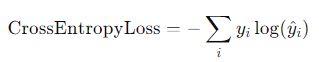

In [32]:
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
def ce_loss(y_true, y_pred):
    return tf.reshape(tfk.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False), (-1, 1, 1))

#### Dice Loss
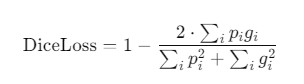

In [71]:
def dice_loss_no_bg(y_true, y_pred):
    """
    Dice Loss ignoring class 0.
    - y_true: (batch, H, W, 1), where the last dimension contains class IDs (integer)
    - y_pred: (batch, H, W, num_classes), usually unnormalized logits
    """
    # 1. Convert labels to one-hot encoding: result is (batch, H, W, num_classes)
    num_classes = tf.shape(y_pred)[-1]  # Or directly use your predefined NUM_CLASSES
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)

    # 2. Apply softmax to logits: convert y_pred to probabilities (batch, H, W, num_classes)
    y_pred_probs = tf.nn.softmax(y_pred, axis=-1)

    # 3. Ignore class 0: retain only classes 1 to (num_classes-1)
    #    For example, class 0 corresponds to y_true_one_hot[...,0] and y_pred_probs[...,0].
    #    We slice [1:] to remove the 0th channel (background).
    y_true_no_bg = y_true_one_hot[..., 1:]  # Shape: (batch, H, W, (num_classes-1))
    y_pred_no_bg = y_pred_probs[..., 1:]    # Shape: (batch, H, W, (num_classes-1))

    # 4. Compute Dice coefficient: numerator = 2 * ∑(p * g), denominator = ∑(p + g)
    numerator = 2.0 * tf.reduce_sum(y_true_no_bg * y_pred_no_bg, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true_no_bg + y_pred_no_bg, axis=(1, 2, 3)) + K.epsilon()

    # 5. Compute Dice loss: dice_loss = 1 - mean(Dice coefficient)
    dice = numerator / denominator
    dice_loss_value = 1.0 - dice

    # Return the mean loss across the batch
    return tf.reduce_mean(dice_loss_value)


#### Focal Loss
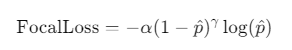

In [34]:

def focal_loss(y_true, y_pred, alpha=None, gamma=2.0):
    """
    Focal Loss with per-class alpha support

    Parameters
    ----------
    y_true : tensor
        True labels, shape [batch_size, ...], where last dimension is 1 or already categorical indices.
    y_pred : tensor
        Predicted logits, shape [batch_size, ..., num_classes].
    alpha : list or tensor
        A list or 1D tensor of shape [num_classes], specifying the weight (alpha) for each class.
        If None, no weighting per class is applied, equivalent to alpha=1 for all classes.
    gamma : float
        The focusing parameter gamma.

    Returns
    -------
    loss : tensor
        Scaler tensor representing the mean focal loss for the batch.
    """

    # Ensure y_true is of shape [batch_size, ..., 1]
    if y_true.shape[-1] != 1:
        # If y_true is already one-hot, we need to convert it back to indices first
        # But if user provided already indices, we can skip this step.
        # We'll assume y_true is class indices
        y_true = tf.argmax(y_true, axis=-1, output_type=tf.int32)

    # Convert y_true from indices to one-hot
    num_classes = tf.shape(y_pred)[-1]
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)

    # Apply softmax to y_pred to get probabilities
    y_pred_prob = tf.nn.softmax(y_pred, axis=-1)

    # Compute cross-entropy (CE = -sum(y_true * log(y_pred_prob)))
    ce = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_prob + K.epsilon()), axis=-1)

    # pt = p_t = probability corresponding to the true class
    # Note: Since ce = -log(pt), we have pt = exp(-ce)
    pt = tf.exp(-ce)

    # If alpha is provided, make sure it is a tensor and has the shape [num_classes]
    if alpha is not None:
        alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
        # For each sample, extract the corresponding alpha by multiplying with y_true_one_hot
        # and summing along classes
        alpha_factor = tf.reduce_sum(y_true_one_hot * alpha, axis=-1)
    else:
        # If no alpha provided, default to 1 for all classes
        alpha_factor = 1.0

    # Compute focal loss
    focal_loss_value = alpha_factor * tf.pow((1 - pt), gamma) * ce

    # Return mean focal loss over the batch
    return tf.reduce_mean(focal_loss_value)

In [69]:
class_alphas = [0, 0.1, 0.1, 0.1, 0.9]


#### Boundary Loss
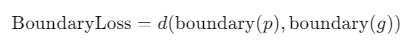

In [70]:
def boundary_loss_no_bg(y_true, y_pred):
    """
    Boundary loss for multi-class semantic segmentation, ignoring class 0:
      - Class 0 is treated as the background, while other classes (1..num_classes-1) are combined into the foreground.
      - Computes boundaries for the foreground and background separately, then constrains predictions using probabilities.

    Args:
      y_true: Integer class labels with shape (batch, H, W) or (batch, H, W, 1),
              where 0 represents the background and 1..N represent multiple foreground classes.
      y_pred: Logits with shape (batch, H, W, num_classes).
    """

    # If y_true has shape (batch, H, W, 1), squeeze it to (batch, H, W)
    if len(y_true.shape) == 4 and y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1)

    # Convert y_true to int32 for comparison
    y_true = tf.cast(y_true, tf.int32)

    # Apply softmax to y_pred to obtain predicted probability distributions (batch, H, W, num_classes)
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    num_classes = tf.shape(y_pred)[-1]

    # 1) Generate the `foreground_mask`:
    #    Class 0 is treated as background, so foreground_mask = (y_true > 0)
    foreground_mask = tf.cast(y_true > 0, tf.float32)  # Shape: (batch, H, W)
    background_mask = 1.0 - foreground_mask           # Shape: (batch, H, W)

    # 2) Compute boundaries for the foreground and background:
    #    Use max pooling (k=3, stride=1) to identify boundary regions.
    #    max_pool requires 4D input (N, H, W, C), so add a channel dimension, then squeeze it back.
    fg_pool = tf.nn.max_pool(foreground_mask[..., None], ksize=3, strides=1, padding='SAME')
    foreground_boundary = tf.squeeze(fg_pool, axis=-1) - foreground_mask

    bg_pool = tf.nn.max_pool(background_mask[..., None], ksize=3, strides=1, padding='SAME')
    background_boundary = tf.squeeze(bg_pool, axis=-1) - background_mask

    # 3) Combine all non-background channels into `foreground_prob`:
    #    Compute the sum of probabilities across y_pred[..., 1..(num_classes-1)] to aggregate multi-class foreground.
    foreground_prob = tf.reduce_sum(y_pred[..., 1:], axis=-1)  # Shape: (batch, H, W)
    # The background probability is simply y_pred[..., 0].

    # 4) Compute the boundary loss:
    #    Similar to the original implementation, but the foreground uses `foreground_prob`
    #    and the background uses `(1 - foreground_prob)`.
    #    Applies penalties at the boundary regions.
    boundary_loss_value = tf.reduce_mean(
        foreground_boundary * foreground_prob + background_boundary * (1.0 - foreground_prob)
    )

    return boundary_loss_value


#### Weighted Cross-Entropy Loss
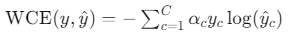

In [37]:
def weighted_cross_entropy_loss(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=tf.shape(y_pred)[-1])
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    weights_list = [class_distribution.get(cls, 0.0) for cls in range(NUM_CLASSES)]
    weights_tensor = 1/tf.constant(weights_list, dtype=tf.float32)

    class_weights_for_samples = tf.reduce_sum(y_true * weights_tensor, axis=-1)

    ce_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-7), axis=-1)
    weighted_loss_value = ce_loss * class_weights_for_samples

    return tf.reduce_mean(tf.reduce_sum(weighted_loss_value, axis=-1))

In [68]:
def weighted_cross_entropy_loss_nozero(y_true, y_pred):
    """
    Weighted cross-entropy loss for Sparse Categorical semantic segmentation.
    - y_true: (batch, H, W, 1), where the last dimension contains class IDs (integers)
    - y_pred: (batch, H, W, NUM_CLASSES), usually logits from the network output

    This function performs:
      1) `squeeze` to remove the single-channel dimension from `y_true`, resulting in y_true=(batch, H, W)
      2) Converts `y_true` to one-hot format, resulting in (batch, H, W, NUM_CLASSES)
      3) Calculates "inverse frequency" weights based on `class_distribution`
      4) Returns the mean scalar loss across all pixels
    """
    # 1) Squeeze the last channel dimension from y_true, resulting in shape (batch, H, W)
    y_true = tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)  # -> (batch, H, W)

    # 2) Convert y_true to one-hot, resulting in y_true_one_hot: (batch, H, W, NUM_CLASSES)
    num_classes = tf.shape(y_pred)[-1]  # Or use the global NUM_CLASSES
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # 3) Apply softmax to y_pred to obtain probabilities: (batch, H, W, NUM_CLASSES)
    y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)

    # Compute "inverse frequency" weights: w_i = 1 / (count_i + 1e-6)
    # `class_distribution` is a dictionary like {class_id: pixel_count}, e.g., {0: 4508320, 1: 6259362, ...}
    weights_list = []
    for cls in range(NUM_CLASSES):
        count = class_distribution.get(cls, 1.0)
        if cls == 0:
            # Completely ignore class 0
            w = 0.0
        else:
            w = 1.0 / (count + 1e-6)  # Or use another weighting method
        weights_list.append(w)

    # Convert weights_list to a Tensor
    weights_tensor = tf.constant(weights_list, dtype=tf.float32)
    # shape: (NUM_CLASSES,)

    # 4) Standard cross-entropy: crossentropy = -∑(y_true_one_hot * log(y_pred_softmax))
    ce_loss = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_softmax + 1e-7), axis=-1)
    # shape: (batch, H, W)

    # 5) Compute pixel-level "class_weights_for_samples"
    #     = ∑(y_true_one_hot * weights_tensor) over classes
    # shape: (batch, H, W)
    class_weights_for_samples = tf.reduce_sum(y_true_one_hot * weights_tensor, axis=-1)

    # Element-wise multiplication => Weighted cross-entropy
    weighted_loss_value = ce_loss * class_weights_for_samples  # shape: (batch, H, W)

    # 6) Global average => Scalar loss
    return tf.reduce_mean(weighted_loss_value)


#### Tversky Loss
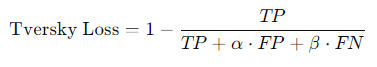

In [39]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_pos = K.sum(y_true * y_pred, axis=[1, 2, 3])

    false_pos = K.sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    false_neg = K.sum(y_true * (1 - y_pred), axis=[1, 2, 3])

    tversky_index = true_pos / (true_pos + alpha * false_pos + beta * false_neg)
    tversky_loss_value = 1 - tversky_index
    return tversky_loss_value

#### Combined Loss

In [40]:
#Combined Loss
def combined_loss(y_true, y_pred):
    ce_loss_value = weighted_cross_entropy_loss_nozero(y_true, y_pred)
    dice_loss_value = dice_loss(y_true, y_pred)
    focal_loss_value = focal_loss(y_true, y_pred,class_alphas)
    boundary_loss_value = boundary_loss_no_bg(y_true, y_pred)

    # return 0.4 * boundary_loss_value + 0.4 * dice_loss_value + 0.2 * focal_loss_value
    return 0.5 * ce_loss_value + 0.2 * dice_loss_value + 0.1 * focal_loss_value + 0.2*boundary_loss_value

In [41]:
# Combined Loss
def combined_loss_one(y_true, y_pred):
    ce_loss_value = weighted_cross_entropy_loss_nozero(y_true, y_pred)
    #dice_loss_value = dice_loss(y_true, y_pred)
    #focal_loss_value = focal_loss(y_true, y_pred,class_alphas)
    #boundary_loss_value = boundary_loss(y_true, y_pred)

    return ce_loss_value

# Combined Loss
def combined_loss_two(y_true, y_pred):
    ce_loss_value = weighted_cross_entropy_loss_nozero(y_true, y_pred)
    dice_loss_value = dice_loss_no_bg(y_true, y_pred)
    focal_loss_value = focal_loss(y_true, y_pred,class_alphas)
    boundary_loss_value = boundary_loss_no_bg(y_true, y_pred)

    # return 0.4 * boundary_loss_value + 0.4 * dice_loss_value + 0.2 * focal_loss_value
    return  0.45 * dice_loss_value + 0.45 * focal_loss_value + 0.1 * boundary_loss_value

# Combined Loss
def combined_loss_three(y_true, y_pred):
    ce_loss_value = weighted_cross_entropy_loss_nozero(y_true, y_pred)
    dice_loss_value = dice_loss_no_bg(y_true, y_pred)
    focal_loss_value = focal_loss(y_true, y_pred,class_alphas)
    boundary_loss_value = boundary_loss_no_bg(y_true, y_pred)

    # return 0.4 * boundary_loss_value + 0.4 * dice_loss_value + 0.2 * focal_loss_value
    return  0.1 * dice_loss_value + 0.1 * focal_loss_value + 0.8 * boundary_loss_value

### Metrics

In [42]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None, **kwargs):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        config = super(MeanIntersectionOverUnion, self).get_config()
        config.update({
            'labels_to_exclude': self.labels_to_exclude
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the custom metric using the config
        return cls(**config)

### Callbacks

In [43]:
import random
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_layer_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)
random_index = random.randint(1, 100)
#viz_callback = VizCallback(X_val[random_index], y_val[random_index])

##🛸Model Compiling

In [44]:
# Compile the model
print("Compiling model...")
model.compile(
    #loss=[combined_loss],
     loss=[combined_loss_one, combined_loss_two, combined_loss_three],  # Provide a loss for each output
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],  # Metrics for the first output
        ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],  # Metrics for the second output
        ["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]   # Metrics for the third output
    ]
)
print("Model compiled!")

Compiling model...
Model compiled!


##🙏Model Trainnig

### Train the model

In [45]:
import tensorflow as tf

def prepare_dataset(dataset):
    return dataset.map(lambda x, y: (x, (
        tf.image.resize(y, [16, 32], method='nearest'),  # Resize for output 0
        tf.image.resize(y, [32, 64], method='nearest'),  # Resize for output 1
        tf.image.resize(y, [64, 128], method='nearest')  # Resize for output 2 to match (64, 128)
    )))
# Adjust your training and validation datasets
train_dataset = prepare_dataset(train_dataset)
val_dataset = prepare_dataset(val_dataset)

In [46]:
for inputs, labels in train_dataset.take(1):  # Take one batch from the dataset
    predictions = model(inputs, training=False)  # Get model outputs without training
    for i, prediction in enumerate(predictions):
        print(f"Output {i} predicted shape: {prediction.shape}, Label shape: {labels[i].shape}")
        assert prediction.shape[1:3] == labels[i].shape[1:3], f"Mismatch in output {i} shape: {prediction.shape} vs {labels[i].shape}"

Output 0 predicted shape: (32, 16, 32, 5), Label shape: (32, 16, 32, 1)
Output 1 predicted shape: (32, 32, 64, 5), Label shape: (32, 32, 64, 1)
Output 2 predicted shape: (32, 64, 128, 5), Label shape: (32, 64, 128, 1)


In [47]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    #epochs=2,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_output_layer_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')


Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 902ms/step - intermediate_output_1_accuracy: 0.2004 - intermediate_output_1_loss: 3.5202e-07 - intermediate_output_1_mean_iou: 0.0929 - intermediate_output_2_accuracy: 0.3254 - intermediate_output_2_loss: 0.3859 - intermediate_output_2_mean_iou: 0.1516 - loss: 0.4849 - output_layer_accuracy: 0.3281 - output_layer_loss: 0.0990 - output_layer_mean_iou: 0.1603 - val_intermediate_output_1_accuracy: 0.2194 - val_intermediate_output_1_loss: 2.9750e-07 - val_intermediate_output_1_mean_iou: 0.0823 - val_intermediate_output_2_accuracy: 0.2097 - val_intermediate_output_2_loss: 0.4033 - val_intermediate_output_2_mean_iou: 0.0683 - val_loss: 0.5060 - val_output_layer_accuracy: 0.2097 - val_output_layer_loss: 0.1027 - val_output_layer_mean_iou: 0.0683
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - intermediate_output_1_accuracy: 0.1920 - intermediate_output_1_loss: 3.5384e-07 - intermediate_output_1_mean_iou: 0.1005 - intermediate_output_2_accura

In [48]:

model_filename = f"model_demo.keras"
model.save(model_filename)
# del model

print(f"Model saved to {model_filename}")

Model saved to model_demo.keras


##Plot Analysis

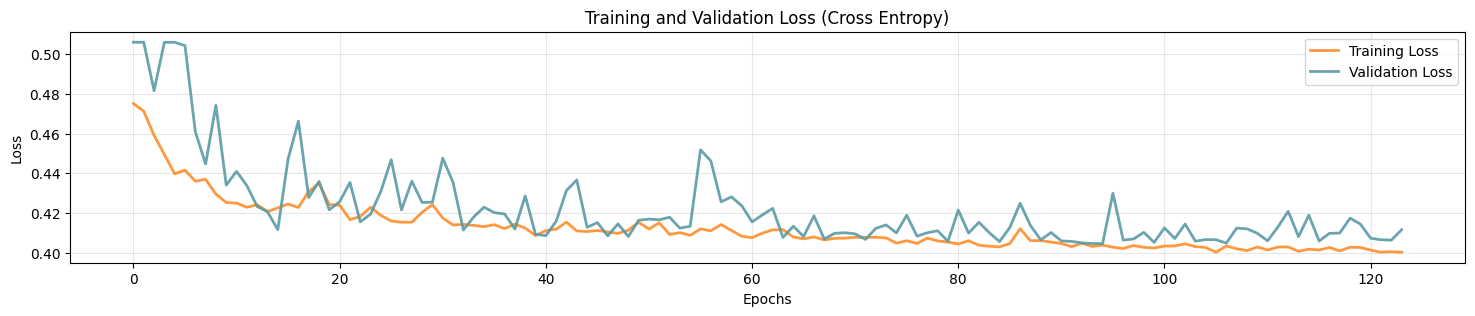

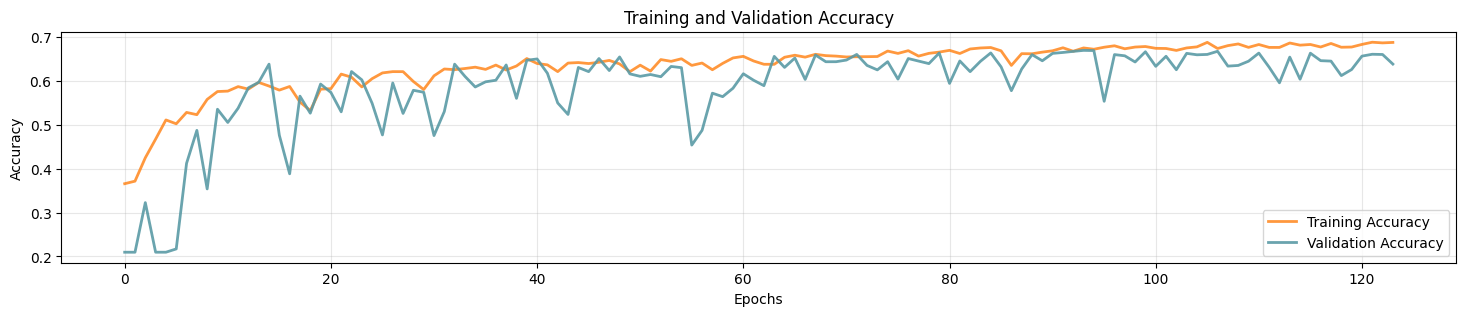

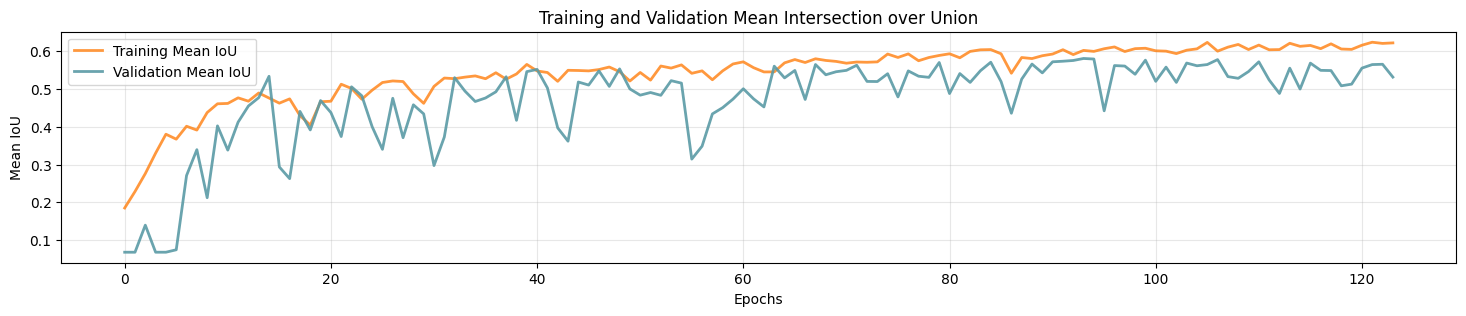

In [54]:
# Assuming history is a dictionary containing training and validation metrics

# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training Loss', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Training and Validation Loss (Cross Entropy)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['output_layer_accuracy'], label='Training Accuracy', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_output_layer_accuracy'], label='Validation Accuracy', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['output_layer_mean_iou'], label='Training Mean IoU', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_output_layer_mean_iou'], label='Validation Mean IoU', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Training and Validation Mean Intersection over Union')

plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [56]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [57]:
model = tfk.models.load_model(model_filename, compile=False)
# print(f"Model loaded from {model_filename}")

In [58]:
# Predict on the test set
predictions = model.predict(X_test)

# Select the prediction from the last layer (output_layer)
predictions = predictions[-1] # Select only the prediction of the final layer

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step


In [59]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [60]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(predicted_classes)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```